In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import lmfit

In [ ]:
xdat = test[0, :]
ydat = test[1, :]

def add_peak(prefix, center, amplitude=0.005, sigma=0.05):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center)
    pars[prefix + 'amplitude'].set(amplitude)
    pars[prefix + 'sigma'].set(sigma, min=0)
    return peak, pars

def multilorentz_fit(xdat, ydat, raw_pikes)
    model = QuadraticModel(prefix='bkg_')
    params = model.make_params(a=0, b=0, c=0)

    rough_peak_positions = (0.61, 0.76, 0.85, 0.99, 1.10, 1.40, 1.54, 1.7)
    for i, cen in enumerate(rough_peak_positions):
        peak, pars = add_peak('lz%d_' % (i+1), cen)
        model = model + peak
        params.update(pars)

    init = model.eval(params, x=xdat)
    result = model.fit(ydat, params, x=xdat)
    comps = result.eval_components()

    print(result.fit_report(min_correl=0.5))

    plt.plot(xdat, ydat, label='data')
    plt.plot(xdat, result.best_fit, label='best fit')
    for name, comp in comps.items():
        plt.plot(xdat, comp, '--', label=name)
    plt.legend(loc='upper right')
    plt.show()

In [2]:
def get_pikes(sygnal, cut=0.05, pike_width=3000):
    smpl = np.copy(sygnal)
    smpl[smpl<= cut] = 0
    pks, *_ = signal.argrelmax(smpl)
    pkds = pks[1:] - pks[:-1]
    stops = pks[np.concatenate((pkds, [pike_width+1])) > pike_width]
    starts = pks[np.concatenate(([pike_width+1], pkds)) > pike_width]
    pks2 = []
    for strt,stp in zip(starts, stops):
        pkc = int((strt+stp)/2)
        lowm = np.argmin(smpl[strt - pike_width : pkc]) + strt - pike_width
        lowp = np.argmin(smpl[pkc : stp + pike_width]) + pkc
        # maxim = np.argmax(smpl[lowm:lowp]) + lowm
        try:
            popt, *_ = optimize.curve_fit(lambda x, a, b, c: a*(x-b)**2 + c, np.arange(lowm, lowp), smpl[lowm : lowp], p0=[1e-3, pkc, 1])
        except RuntimeError:
            plt.subplot(211)
            plt.plot(sygnal[lowm:lowp])
            plt.subplot(212)
            plt.plot(sygnal)
        maxim = popt[1]
        pks2.append(maxim)

    pks2 = np.asarray(pks2)
    return pks2

In [2]:
def read_spectrum_csv(path):
    with open(path, 'r') as file:
        next(file)
        next(file)
        start = int(next(file))
        file.close()
        return pd.read_csv(path, skiprows=start+4, names=["Frequency", "Level"], usecols=[0,1]).to_numpy()

In [3]:
data = read_spectrum_csv("24.04.23/X204mA.CSV")

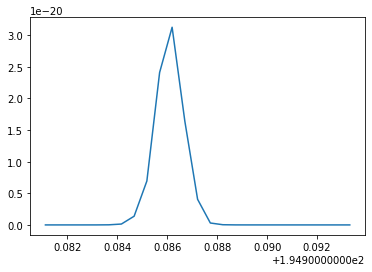

In [16]:
r = np.arange(625,650)
plt.plot(data[r,0], np.exp(data[r,1]))
plt.show()

In [78]:
quad = lmfit.models.QuadraticModel()
pike = lmfit.models.LorentzianModel()
LM = pike + quad
parsQ = quad.guess(data[:,1], data[:,0])
parsV = pike.guess(data[:,1] - quad.eval(parsQ, x=data[:,0]), data[:,0])
if type(pike) == lmfit.models.VoigtModel:
    parsV["gamma"].set(value=parsV["gamma"].value, vary=True)
params = LM.make_params()
params.update(parsQ)
params.update(parsV)
fit = LM.fit(data[:,1], params, x=data[:,0])

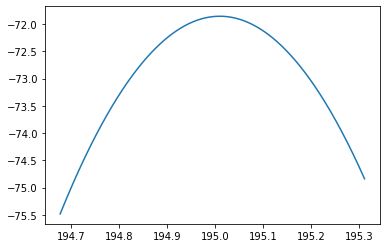

In [79]:
plt.plot(data[:,0],quad.eval(parsQ, x=data[:,0]))

In [80]:
params

name,value,initial value,min,max,vary,expression
amplitude,0.49444052,0.49444051758828644,-inf,inf,True,
center,194.986204,194.98620368421055,-inf,inf,True,
sigma,0.00456500,0.004564999999999486,0.00000000,inf,True,
fwhm,0.00913000,None,-inf,inf,False,2.0000000*sigma
height,34.4765195,None,-inf,inf,False,"0.3183099*amplitude/max(1e-15, sigma)"
a,-32.8035925,-32.80359246172168,-inf,inf,True,
b,12794.0126,12794.012619147568,-inf,inf,True,
c,-1247547.72,-1247547.7164372227,-inf,inf,True,


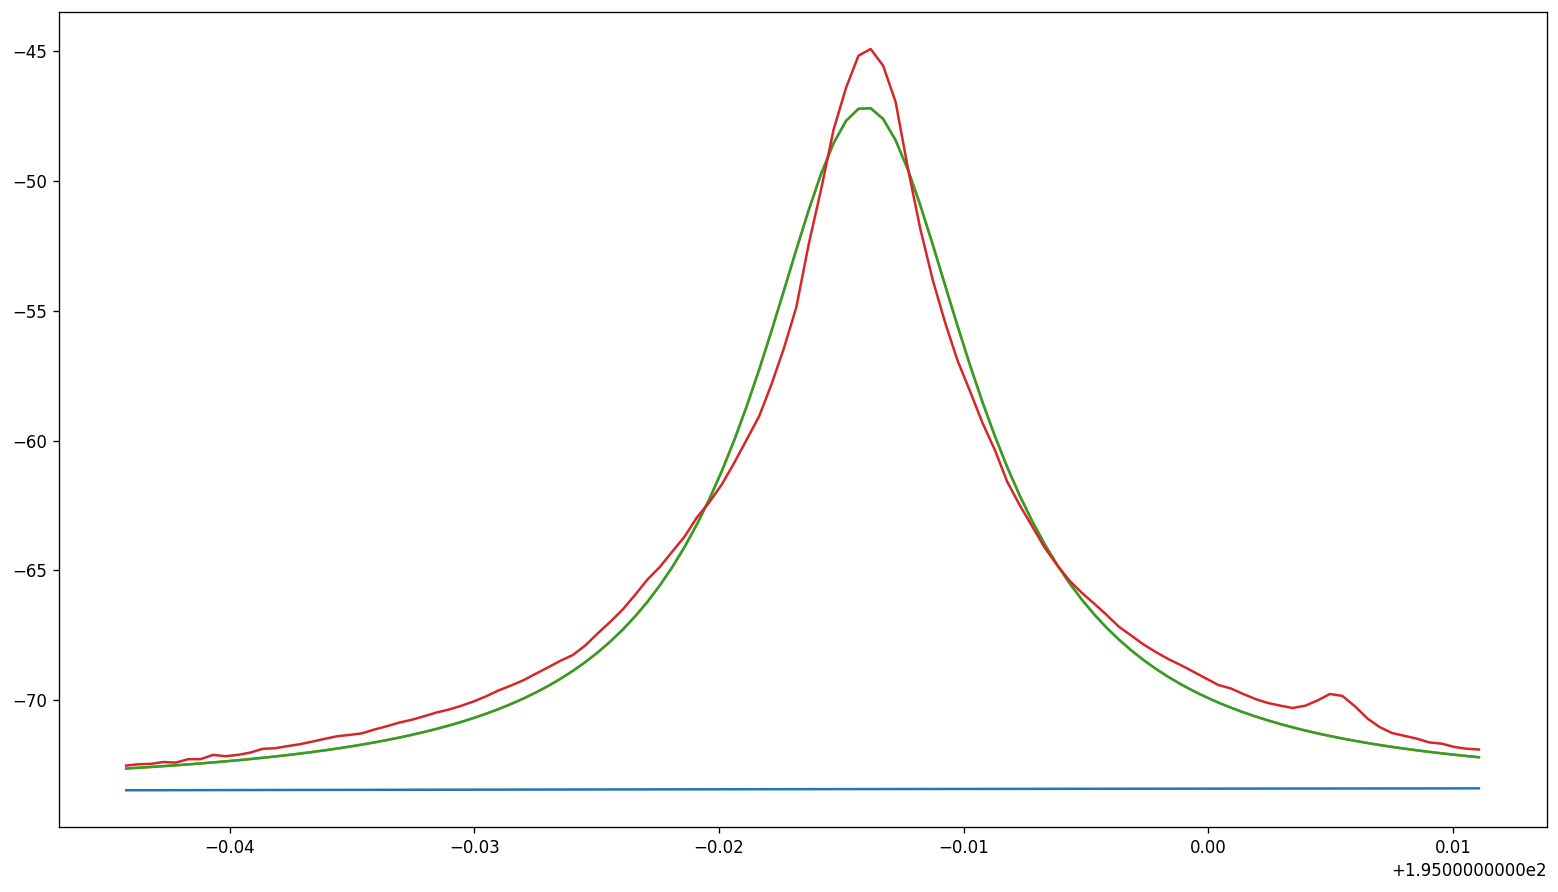

In [81]:
r = np.arange(590,700)
# r = np.arange(0,1000)
plt.figure(dpi=120, figsize=(16,9))
# plt.plot(data[r,0], np.log(fit.init_fit[r]))
plt.plot(data[r,0],quad.eval(fit.params, x=data[r,0]))
plt.plot(data[r,0],pike.eval(fit.params, x=data[r,0])+quad.eval(fit.params, x=data[r,0]))
plt.plot(data[r,0], fit.best_fit[r])
#plt.plot(data[:,0], np.log(LMinit))
plt.plot(data[r,0], data[r,1])
plt.show()

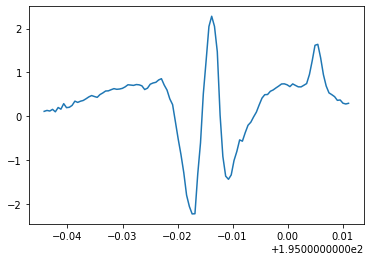

In [73]:
plt.plot(data[r,0], data[r,1] - fit.best_fit[r])

In [59]:
print(fit.fit_report())

[[Model]]
    (Model(voigt) + Model(parabolic))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 1251
    # variables        = 7
    chi-square         = 693.242830
    reduced chi-square = 0.55726916
    Akaike info crit   = -724.488030
    Bayesian info crit = -688.566140
    R-squared          = 0.94375549
[[Variables]]
    amplitude:  0.45831784 +/- 0.00655997 (1.43%) (init = 0.5933286)
    center:     194.985976 +/- 5.7139e-05 (0.00%) (init = 194.9862)
    sigma:      1.4073e-05 +/- 0.03224532 (229133.86%) (init = 0.00296725)
    gamma:      0.00556064 +/- 1.9067e-04 (3.43%) (init = 0.00296725)
    fwhm:       0.01112143 +/- 2.2014e-04 (1.98%) == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:     26.2354834 +/- 0.33132321 (1.26%) == '(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))).real'
    a:         -5.54297626 +/- 0.77993037 (14.07%) (init = -32.80359)
    b:     

In [57]:
fit.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,0.45831784,0.00655997,(1.43%),0.5933286211059436,-inf,inf,True,
center,194.985976,5.7139e-05,(0.00%),194.98620368421055,-inf,inf,True,
sigma,1.4073e-05,0.03224532,(229133.86%),0.002967249999999666,0.00000000,inf,True,
gamma,0.00556064,1.9067e-04,(3.43%),0.002967249999999666,-inf,inf,True,
fwhm,0.01112143,2.2014e-04,(1.98%),0.010685929646162542,-inf,inf,False,1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)
height,26.2354834,0.33132321,(1.26%),41.73331860246939,-inf,inf,False,"(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))).real"
a,-5.54297626,0.77993037,(14.07%),-32.80359246172168,-inf,inf,True,
b,2162.88269,304.162078,(14.06%),12794.012619147568,-inf,inf,True,
c,-211063.938,29654.7268,(14.05%),-1247547.7164372227,-inf,inf,True,
